In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# importing all the required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import IPython.display as ipd

In [14]:
from torchvision import transforms
from tqdm import tqdm

In [7]:
import glob
from PIL import Image

In [16]:
visual_images_path = '/content/visual_frames_final'
all_image_files = sorted(glob.glob('/content/visual_frames_final/*/*.jpg'))

In [9]:
all_audio_files = sorted(glob.glob('/content/Audio*/*/*.wav'))

In [10]:
# from tqdm import tqdm

# IMAGES = []
# for impath in tqdm(image_files):
#   img = Image.open(impath)
#   IMAGES.append(img)

In [11]:
len(all_audio_files), len(all_image_files)

(2496, 62042)

In [12]:
label_to_emotion = {'01':'neutral', 
                    '02': 'calm', 
                    '03': 'happy',
                    '04': 'sad',
                    '05': 'angry',
                    '06': 'fearful',
                    '07': 'disgust',
                    '08': 'surprised'}

In [17]:
FILES = {'filepath':[], 
         'label':[], 
         'emotion': [],
         'actor':[], 
         'intensity': [], 
         'duration': [],
         'image_paths': []}
want_duration = False
for wav_file in tqdm(all_audio_files):
  filename = wav_file.replace('.wav', '')
  label = os.path.basename(filename).split('-')[2]
  intensity = os.path.basename(filename).split('-')[3]
  actor = os.path.basename(filename).split('-')[-1]
  
  # filling the dictionary
  FILES['filepath'].append(wav_file)
  FILES['label'].append(label)
  FILES['emotion'].append(label_to_emotion[label])
  FILES['actor'].append(actor)
  FILES['intensity'].append(intensity)
  if want_duration:
    FILES['duration'].append(librosa.get_duration(filename=wav_file))
  else:
    FILES['duration'].append(0.0)
  
  # for video face extraction
  video_file = wav_file
  vid_tag = "=".join(video_file.split('/')[-2:]).replace('.wav', '')
  label = os.path.basename(video_file).split('-')[2]
  label_dir = os.path.join(visual_images_path, label)

  savepath = os.path.join(label_dir, f'{vid_tag}=*.jpg').replace('=03-', '=01-')
  imgpaths = sorted(glob.glob(savepath)) or 'NAH'

  FILES['image_paths'].append(imgpaths)


100%|██████████| 2496/2496 [00:25<00:00, 98.63it/s] 


In [18]:
df = pd.DataFrame(FILES)
df

,filepath,label,emotion,actor,intensity,duration,image_paths
0,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
1,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
2,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
3,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
4,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,02,calm,01,01,0.0,[/content/visual_frames_final/02/Actor_01=01-0...
...,...,...,...,...,...,...,...
2491,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,01,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2492,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2493,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2494,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...


In [19]:
# df.iloc[0].image_paths

In [20]:
from collections import Counter

Counter(df.emotion)

Counter({'angry': 384,
         'calm': 384,
         'disgust': 192,
         'fearful': 384,
         'happy': 384,
         'neutral': 192,
         'sad': 384,
         'surprised': 192})

In [21]:
# to split the data into training and validation
from sklearn.model_selection import train_test_split

In [22]:
train_df, dev_df = train_test_split(df, shuffle=True, stratify=df['label'], test_size=0.15, random_state=6)
dev_df, test_df = train_test_split(dev_df, shuffle=True, stratify=dev_df['label'], test_size=0.5, random_state=6)

train_df.shape, dev_df.shape, test_df.shape

((2121, 7), (187, 7), (188, 7))

In [23]:
train_df = train_df[train_df.image_paths!='NAH']
dev_df = dev_df[dev_df.image_paths!='NAH']
test_df = test_df[test_df.image_paths!='NAH']

train_df.shape, dev_df.shape, test_df.shape

((2075, 7), (183, 7), (184, 7))

In [24]:
print(Counter(train_df.emotion))
print(Counter(dev_df.emotion))
print(Counter(test_df.emotion))

Counter({'sad': 321, 'fearful': 320, 'happy': 319, 'angry': 319, 'calm': 316, 'surprised': 163, 'disgust': 163, 'neutral': 154})
Counter({'happy': 29, 'angry': 28, 'sad': 28, 'calm': 28, 'fearful': 27, 'disgust': 15, 'surprised': 15, 'neutral': 13})
Counter({'angry': 29, 'fearful': 29, 'calm': 29, 'happy': 28, 'sad': 27, 'neutral': 14, 'surprised': 14, 'disgust': 14})


In [25]:
SAMPLE_RATE = 16000
NMFCCs = 13

In [26]:
# t = 13
# r = 3
# kk = np.arange(t)
# for i in range(0, t, r):
#   kk_ = kk[i:i+r]
#   if len(kk_)!=r:
#     kk_ = kk[i - r + len(kk_):]
#   print(kk_)

In [27]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [28]:
class AudioVideoDataset(torch.utils.data.Dataset):
  def __init__(self, df, transforms):
    self.df = df
    self.transforms = transforms
    self.duration_required = 2 #2seconds
    self.images_required = 4
    self.audio_data = {}
    self.video_data = {}
    # load all the audio files and convert them into spectrograms 
    print("Loading all the audio and video files on to RAM...")
    self.DATAHANDLES = []

    for lineno in tqdm(range(self.df.shape[0])):
      line = self.df.iloc[lineno]
      wavpath = line.filepath
      audio_duration = librosa.get_duration(filename=wavpath)
      audio, sr = librosa.load(wavpath, 
                             sr=SAMPLE_RATE, 
                             duration=self.duration_required, 
                             offset=audio_duration/2 - self.duration_required/2)
      mel_spec = librosa.feature.mfcc(audio, sr=SAMPLE_RATE, n_mfcc=NMFCCs)
      self.audio_data[wavpath] = mel_spec

      for imgpath in line.image_paths:
        img = Image.open(imgpath)
        self.video_data[imgpath] = img

      for ino in range(0, len(line.image_paths), self.images_required):
        imgs = line.image_paths[ino:ino+self.images_required]
        # print("LEN", len(imgs), len(line.image_paths))
        if len(imgs) != self.images_required:
          imgs = line.image_paths[max(0, ino - self.images_required - len(imgs)):]
          # print("broke len", len(imgs), len(line.image_paths))
        if len(imgs) != self.images_required: 
          # print("Assertion failed for ", lineno)
          continue
        self.DATAHANDLES.append({'label':line.label, 'audio':line.filepath, 'video':imgs})

    print(f"Done loading: Audio data: {len(self.audio_data)}\tVideo files: {len(self.video_data)}")
    print(f"Total Samples here: {len(self.DATAHANDLES)}")

  def __len__(self):
    return len(self.DATAHANDLES)
  def __getitem__(self, idx):
    line = self.DATAHANDLES[idx]
    label = int(line['label']) - 1
    mel_spec = torch.Tensor(self.audio_data[line['audio']])
    images = torch.cat([self.transforms(self.video_data[x]) for x in line['video']], dim=2)
    return torch.Tensor(mel_spec), images, torch.Tensor([label])

In [30]:
train_dataset = AudioVideoDataset(train_df, train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               shuffle=True, 
                                               batch_size=128, 
                                               num_workers=8)

dev_dataset = AudioVideoDataset(dev_df, test_transforms)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             num_workers=8)


test_dataset = AudioVideoDataset(test_df, test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             num_workers=8)




Loading all the audio and video files on to RAM...


100%|██████████| 2075/2075 [04:18<00:00,  8.03it/s]


Done loading: Audio data: 2075	Video files: 26316
Total Samples here: 5705
Loading all the audio and video files on to RAM...


100%|██████████| 183/183 [00:22<00:00,  8.08it/s]


Done loading: Audio data: 183	Video files: 2314
Total Samples here: 498
Loading all the audio and video files on to RAM...


100%|██████████| 184/184 [00:23<00:00,  8.00it/s]

Done loading: Audio data: 184	Video files: 2333
Total Samples here: 505


In [31]:
print(len(train_dataset), len(dev_dataset), len(test_dataset))
print(len(train_dataloader), len(dev_dataloader), len(test_dataloader))

5705 498 505
45 16 16


In [95]:
# audio model for our multimodal training
class BasicAudioRnnModel(torch.nn.Module):
  def __init__(self, input_size=128, hidden_size=512,num_layers=3, isBidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.linearIn = 2*hidden_size if isBidirectional else hidden_size
    self.rnn = torch.nn.GRU(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers,
                            batch_first=True, 
                            dropout = 0.3, #only for GRU and LSTM not for RNN
                            bidirectional=isBidirectional) #Test with unidirectional
    # self.linear = torch.nn.Linear(self.linearIn, num_classes) 
    self.out_shape = self.linearIn
  def forward(self, X):
    out, h = self.rnn(X)
    out_required = out[:, -1, :]
    # yhat = self.linear(out_required)
    return out_required

In [96]:
def get_padding_dims_same(in_height=64, in_width=64, filter_height=3, filter_width=3, strides=(None, 1, 1)):
    out_height = np.ceil(float(in_height) / float(strides[1]))
    out_width  = np.ceil(float(in_width) / float(strides[2]))

    if (in_height % strides[1] == 0): pad_along_height = max(filter_height - strides[1], 0)
    else: pad_along_height = max(filter_height - (in_height % strides[1]), 0)
    if (in_width % strides[2] == 0): pad_along_width = max(filter_width - strides[2], 0)
    else: pad_along_width = max(filter_width - (in_width % strides[2]), 0)
    pad_top = pad_along_height // 2; pad_bottom = pad_along_height - pad_top; pad_left = pad_along_width // 2
    pad_right = pad_along_width - pad_left
    return (pad_left + pad_right)//2, (pad_top + pad_bottom)//2
    return (pad_left, pad_right, pad_top, pad_bottom)

def get_output_size_convs(H, W, KW, KH, S, P):
    outputW = 1 + (W - KW + 2*P)//S
    outputH = 1 + (H - KH + 2*P)//S
    return outputW, outputH

In [97]:

class ResBlock(nn.Module):
    def __init__(self, W, H, params):
        super().__init__()
        self.params = params
        padding_dims1 = get_padding_dims_same(W, H, 
                                              params[0]['kernel_size'], 
                                              params[0]['kernel_size'],
                                              (None, params[0]['stride'], params[0]['stride']))
        self.conv1 = nn.Conv2d(params[0]['in_channels'], 
                               params[0]['out_channels'], 
                               kernel_size=params[0]['kernel_size'], 
                               stride=params[0]['stride'],
                               padding=padding_dims1)
        self.bn1 = nn.BatchNorm2d(params[0]['out_channels'])
        self.relu = nn.ReLU()
        
        padding_dims2 = get_padding_dims_same(W, H, 
                                              params[0]['kernel_size'], 
                                              params[0]['kernel_size'],
                                              (None, params[0]['stride'], params[0]['stride']))
        
        
        self.conv2 = nn.Conv2d(params[1]['in_channels'], 
                               params[1]['out_channels'], 
                               kernel_size=params[1]['kernel_size'], 
                               stride=params[1]['stride'],
                               padding=padding_dims2)
        self.bn2 = nn.BatchNorm2d(params[1]['out_channels'])
        if params[1]['channel_resizer']:
            self.channel_resizer = nn.Conv2d(params[0]['in_channels'], params[1]['out_channels'], kernel_size=1, stride=1)
        else:
            self.channel_resizer = nn.Identity()
        
    def forward(self, X):
        IN = X
#         print("0", X.shape)
        
        out = self.conv1(X)
#         print("1", out.shape)
        
        out = self.bn1(out)
#         print("2", out.shape)
        
        out = self.relu(out)
#         print("3", out.shape)
        
        out = self.conv2(out)
#         print("4", out.shape)
        IN = self.channel_resizer(IN)
#         print("5", IN.shape)
        
        out += IN
#         print("6", out.shape)
        return self.relu(out)

    
class NormalConvBlock(nn.Module):
    def __init__(self, W=64, H=64, params=None):
        super().__init__()
        self.params = params
        self.W = W
        self.H = H
        self.conv1 = nn.Conv2d(params['in_channels'], 
                               params['out_channels'],
                              kernel_size=params['kernel_size'],
                              stride=params['stride'])
        self.pool = nn.AvgPool2d(kernel_size=params['pool_kernel_size'], 
                                   stride=params['pool_stride'])
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.conv1(X)
        out = self.pool(out)
        out = self.relu(out)
        return out
    def get_output_size(self):
        w, h = get_output_size_convs(self.W, self.H, 
                                     self.params['kernel_size'], self.params['kernel_size'],
                                     self.params['stride'], 0)
        w, h = get_output_size_convs(w, h, 
                                     self.params['pool_kernel_size'], self.params['pool_kernel_size'],
                                     self.params['pool_stride'], 0)
        return self.params['out_channels'], w, h


class MyVideoSimpleModel(nn.Module):
    def __init__(self, W=64, H=64, hyperparameters=None, classes=4000):
        super().__init__()
        normal_params = hyperparameters['normal_params']
        resnet_params = hyperparameters['resnet_params']
        n_resnet_blocks = hyperparameters['n_resnet_blocks']
        
        layers = []
        
        w, h = W, H
        for i, n_params in enumerate(normal_params):
            layers.append(NormalConvBlock(w, h, n_params))
            c, w, h = layers[-1].get_output_size()
            print(c, w, h)
            
        print(f"Normal Inputs to ResBlocks: W: {w} H: {h}")
        
        for i in range(n_resnet_blocks):
            layers.append(ResBlock(W, H, resnet_params))
        
        self.net = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        
        self.out_shape = c*w*h
        
        # self.linear1 = nn.Linear(c*w*h, 1500)
        # self.tanh = nn.Tanh()
        # self.linear2 = nn.Linear(1500, classes)

    def forward(self, X, form='nlwc', return_bn=False):
        if form=='nlwc':
            X = X.permute(0, 3, 1, 2)
        out = self.net(X)
        out = self.flatten(out)
        # out = self.linear1(out)
        # out = self.tanh(out)
        # self.bottlenecks = out
        # out = self.linear2(out)
        # if return_bn: 
        #         return out, self.bottlenecks
        return out

In [98]:
class AudioVideoMMmodel3(nn.Module):
    def __init__(self, audio_hyperparameters, video_hyperparameters, classes=8):
        super().__init__()
        self.audio_model = BasicAudioRnnModel(audio_hyperparameters['INPUT_SIZE'], 
                                              audio_hyperparameters['N_HIDDEN'], 
                                              audio_hyperparameters['NUM_LAYERS'],  
                                              audio_hyperparameters['IS_BIDIRECTIONAL'])
        
        self.video_model = MyVideoSimpleModel(hyperparameters=video_hyperparameters, W=256, H=64)

        self.in_shape = self.audio_model.out_shape + self.video_model.out_shape
        print(f"Audio Vector Size: {self.audio_model.out_shape}\nVideo Vector Shape: {self.video_model.out_shape}\nConcatenated: {self.in_shape}")
        self.final_classifier = torch.nn.Linear(self.in_shape, classes)
    def forward(self, audio, video, verbose=False):
      audio_out = self.audio_model(audio)
      video_out = self.video_model(video, form='nclw')
      concatenated_vector = torch.cat([audio_out, video_out], dim=1)
      if verbose:
        print(f"Concatenated vector shape: {concatenated_vector.shape}")
      out = self.final_classifier(concatenated_vector)
      return out

In [99]:
# hyperparameters of my model for easy versioning is stored in a dictionary and later into a yaml file. 

# video model
normal_params = [{'in_channels':3, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2}]

resnet_params = [{'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'channel_resizer':False},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'channel_resizer':False}]
n_resnet_blocks = 5

video_hyperparameters = {'normal_params':normal_params,
                   'resnet_params':resnet_params,
                   'n_resnet_blocks':n_resnet_blocks}

# audio hyperparameters
audio_hyperparameters = {
    'INPUT_SIZE': 13,
    'N_HIDDEN': 512,
    'NUM_LAYERS':3,
    'IS_BIDIRECTIONAL': True
}

full_hyperparameters = {'audio_hyperparameters': audio_hyperparameters, 
                        'video_hyperparameters': video_hyperparameters}        

In [100]:
# audio.shape, video.shape, label.shape
full_hyperparameters

{'audio_hyperparameters': {'INPUT_SIZE': 13,
  'IS_BIDIRECTIONAL': True,
  'NUM_LAYERS': 3,
  'N_HIDDEN': 512},
 'video_hyperparameters': {'n_resnet_blocks': 5,
  'normal_params': [{'in_channels': 3,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1}],
  'resnet_params': [{'channel_resizer': False,
    'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'stride': 1},
   {'channel_resizer': False,
    'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'stride': 1}]}}

In [101]:
DEVICE = 'cuda'

In [102]:
av_model_3 = AudioVideoMMmodel3(audio_hyperparameters, video_hyperparameters)
av_model_3.to(DEVICE)

128 127 31
128 62 14
128 30 6
128 14 2
Normal Inputs to ResBlocks: W: 14 H: 2
Audio Vector Size: 1024
Video Vector Shape: 3584
Concatenated: 4608


AudioVideoMMmodel3(
  (audio_model): BasicAudioRnnModel(
    (rnn): GRU(13, 512, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  )
  (video_model): MyVideoSimpleModel(
    (net): Sequential(
      (0): NormalConvBlock(
        (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (1): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (2): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (3): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (4): ResBlock(
        (co

In [103]:
# outs = av_model_3(audio.permute(0, 2, 1), video, verbose=True)

In [104]:
# outs.shape

In [105]:
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(av_model_3.parameters(), lr=0.001) #initial lr=0.01
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=1)

In [106]:
def get_accuracy(yhat, y):
  return (yhat.argmax(1)==y).float().mean()


def train_one_epoch_audiovideov3(model, dataset, criterion, optim, epoch):
  model.train()
  losses = []
  accus = []
  stime = time.time()
  pbar = tqdm(dataset)
  for i, batch in enumerate(pbar):
    audiofeats = batch[0].to(DEVICE)
    videofeats = batch[1].to(DEVICE)
    labels = batch[2].flatten().to(DEVICE)

    outs = model(torch.permute(audiofeats, (0, 2, 1)), videofeats)

    optim.zero_grad()
    l = criterion(outs, labels.long())
    l.backward()
    optim.step()

    losses.append(l.item())
    accu = get_accuracy(outs, labels)
    accus.append(accu.item())

    accuracy_avg = sum(accus)/len(accus)
    loss_avg = sum(losses)/len(losses)
    pbar.set_description(f"Progress - Accu: {accuracy_avg:.3f}\tLoss: {loss_avg:.3f}")

  etime = time.time()
  accuracy_avg = sum(accus)/len(accus)
  loss_avg = sum(losses)/len(losses)
  time_total = etime - stime
  print(f'[TRAIN] Epoch: {epoch}\tAccu: {accuracy_avg}\tLoss: {loss_avg}\tTime: {time_total:.3f} secs')
  return loss_avg, accuracy_avg, time_total

@torch.no_grad()
def evaluate_model(model, dataset, criterion, epoch):
  model.eval()
  losses = []
  accus = []
  stime = time.time()
  for i, batch in enumerate(dataset):
    audiofeats = batch[0].to(DEVICE)
    videofeats = batch[1].to(DEVICE)
    labels = batch[2].flatten().to(DEVICE)

    outs = model(torch.permute(audiofeats, (0, 2, 1)), videofeats)

    l = criterion(outs, labels.long())

    losses.append(l.item())
    accu = get_accuracy(outs, labels)
    accus.append(accu.item())
  etime = time.time()
  accuracy_avg = sum(accus)/len(accus)
  loss_avg = sum(losses)/len(losses)
  time_total = etime - stime
  print(f'[VALID] Epoch: {epoch}\tAccu: {accuracy_avg}\tLoss: {loss_avg}\tTime: {time_total:.3f} secs')
  return loss_avg, accuracy_avg, time_total

In [107]:
# res = train_one_epoch_audiovideov3(av_model_3, train_dataloader, criterion, optim, epoch=2)

In [108]:
# res_dv = evaluate_model(av_model_3, dev_dataloader, criterion, epoch=1)

In [109]:
get_lr = lambda optim: optim.param_groups[0]['lr']

In [110]:
N_EPOCHS = 50
for epoch in range(1, N_EPOCHS + 1):
  # training the model for one epoch
  print(f"Starting Training epoch: {epoch}")
  train_loss_avg, train_accuracy_avg, train_time_total = train_one_epoch_audiovideov3(av_model_3, train_dataloader, criterion, optim, epoch)

  # evaluate the model one epoch
  print(f"Starting Evaluation epoch: {epoch}")
  dev_loss_avg, dev_accuracy_avg, dev_time_total = evaluate_model(av_model_3, dev_dataloader, criterion, epoch)

  # scheduler
  scheduler.step(dev_loss_avg)
  print(f"Learning rate at epoch: {epoch} is {get_lr(optim)}")

Starting Training epoch: 1


Progress - Accu: 0.375	Loss: 1.734: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 1	Accu: 0.3745505134264628	Loss: 1.7340491003460354	Time: 15.373 secs
Starting Evaluation epoch: 1


[VALID] Epoch: 1	Accu: 0.4947916669771075	Loss: 1.3662183955311775	Time: 1.206 secs
Learning rate at epoch: 1 is 0.001
Starting Training epoch: 2


Progress - Accu: 0.604	Loss: 1.046: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 2	Accu: 0.6038051750924852	Loss: 1.0464646922217475	Time: 15.379 secs
Starting Evaluation epoch: 2


[VALID] Epoch: 2	Accu: 0.6085069440305233	Loss: 1.1124878861010075	Time: 1.202 secs
Learning rate at epoch: 2 is 0.001
Starting Training epoch: 3


Progress - Accu: 0.736	Loss: 0.709: 100%|██████████| 45/45 [00:15<00:00,  2.97it/s]

[TRAIN] Epoch: 3	Accu: 0.7359303646617465	Loss: 0.7086867332458496	Time: 15.154 secs
Starting Evaluation epoch: 3


[VALID] Epoch: 3	Accu: 0.7378472238779068	Loss: 0.7995018139481544	Time: 1.165 secs
Learning rate at epoch: 3 is 0.001
Starting Training epoch: 4


Progress - Accu: 0.824	Loss: 0.482: 100%|██████████| 45/45 [00:15<00:00,  2.95it/s]

[TRAIN] Epoch: 4	Accu: 0.8244316021601359	Loss: 0.48159551521142324	Time: 15.265 secs
Starting Evaluation epoch: 4


[VALID] Epoch: 4	Accu: 0.7575954869389534	Loss: 0.7391549916937947	Time: 1.235 secs
Learning rate at epoch: 4 is 0.001
Starting Training epoch: 5


Progress - Accu: 0.889	Loss: 0.310: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 5	Accu: 0.8888413243823581	Loss: 0.3099839597940445	Time: 15.329 secs
Starting Evaluation epoch: 5


[VALID] Epoch: 5	Accu: 0.7764756940305233	Loss: 0.6346897576004267	Time: 1.223 secs
Learning rate at epoch: 5 is 0.001
Starting Training epoch: 6


Progress - Accu: 0.931	Loss: 0.191: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 6	Accu: 0.9309455858336555	Loss: 0.19096362541119258	Time: 15.350 secs
Starting Evaluation epoch: 6


[VALID] Epoch: 6	Accu: 0.7408854179084301	Loss: 0.9289667438715696	Time: 1.171 secs
Learning rate at epoch: 6 is 0.001
Starting Training epoch: 7


Progress - Accu: 0.961	Loss: 0.108: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 7	Accu: 0.9605450908342997	Loss: 0.10823010429739952	Time: 15.358 secs
Starting Evaluation epoch: 7


[VALID] Epoch: 7	Accu: 0.8094618059694767	Loss: 0.6735450010746717	Time: 1.195 secs
Learning rate at epoch: 7 is 0.0005
Starting Training epoch: 8


Progress - Accu: 0.986	Loss: 0.048: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 8	Accu: 0.9862847222222222	Loss: 0.048303637488020794	Time: 15.302 secs
Starting Evaluation epoch: 8


[VALID] Epoch: 8	Accu: 0.8522135429084301	Loss: 0.6255608292995021	Time: 1.198 secs
Learning rate at epoch: 8 is 0.0005
Starting Training epoch: 9


Progress - Accu: 0.998	Loss: 0.016: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 9	Accu: 0.9980902777777778	Loss: 0.01568611276646455	Time: 15.304 secs
Starting Evaluation epoch: 9


[VALID] Epoch: 9	Accu: 0.8530815988779068	Loss: 0.6583807468414307	Time: 1.247 secs
Learning rate at epoch: 9 is 0.0005
Starting Training epoch: 10


Progress - Accu: 0.999	Loss: 0.006: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 10	Accu: 0.9994791666666667	Loss: 0.006242389387140671	Time: 15.341 secs
Starting Evaluation epoch: 10


[VALID] Epoch: 10	Accu: 0.8736979179084301	Loss: 0.6373761377763003	Time: 1.140 secs
Learning rate at epoch: 10 is 0.00025
Starting Training epoch: 11


Progress - Accu: 1.000	Loss: 0.004: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 11	Accu: 0.9998263888888889	Loss: 0.003616218669857416	Time: 15.284 secs
Starting Evaluation epoch: 11


[VALID] Epoch: 11	Accu: 0.8756510429084301	Loss: 0.6147791947005317	Time: 1.232 secs
Learning rate at epoch: 11 is 0.00025
Starting Training epoch: 12


Progress - Accu: 1.000	Loss: 0.003: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 12	Accu: 1.0	Loss: 0.0026879483161287177	Time: 15.329 secs
Starting Evaluation epoch: 12


[VALID] Epoch: 12	Accu: 0.8756510429084301	Loss: 0.6253569910186343	Time: 1.205 secs
Learning rate at epoch: 12 is 0.00025
Starting Training epoch: 13


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 13	Accu: 1.0	Loss: 0.002174590359855857	Time: 15.312 secs
Starting Evaluation epoch: 13


[VALID] Epoch: 13	Accu: 0.8736979179084301	Loss: 0.6265009962662589	Time: 1.251 secs
Learning rate at epoch: 13 is 0.000125
Starting Training epoch: 14


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 14	Accu: 1.0	Loss: 0.0017702932495416866	Time: 15.291 secs
Starting Evaluation epoch: 14


[VALID] Epoch: 14	Accu: 0.8736979179084301	Loss: 0.6272887091618031	Time: 1.232 secs
Learning rate at epoch: 14 is 0.000125
Starting Training epoch: 15


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 15	Accu: 1.0	Loss: 0.0017719221068546176	Time: 15.356 secs
Starting Evaluation epoch: 15


[VALID] Epoch: 15	Accu: 0.8756510429084301	Loss: 0.6349157579534221	Time: 1.146 secs
Learning rate at epoch: 15 is 6.25e-05
Starting Training epoch: 16


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.91it/s]

[TRAIN] Epoch: 16	Accu: 1.0	Loss: 0.0016835884760237401	Time: 15.447 secs
Starting Evaluation epoch: 16


[VALID] Epoch: 16	Accu: 0.8717447929084301	Loss: 0.637461071513826	Time: 1.185 secs
Learning rate at epoch: 16 is 6.25e-05
Starting Training epoch: 17


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.95it/s]

[TRAIN] Epoch: 17	Accu: 1.0	Loss: 0.0016091407444845472	Time: 15.246 secs
Starting Evaluation epoch: 17


[VALID] Epoch: 17	Accu: 0.8776041679084301	Loss: 0.6322112843918148	Time: 1.211 secs
Learning rate at epoch: 17 is 3.125e-05
Starting Training epoch: 18


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.95it/s]

[TRAIN] Epoch: 18	Accu: 1.0	Loss: 0.0015934577793814241	Time: 15.283 secs
Starting Evaluation epoch: 18


[VALID] Epoch: 18	Accu: 0.8756510429084301	Loss: 0.635706845583627	Time: 1.176 secs
Learning rate at epoch: 18 is 3.125e-05
Starting Training epoch: 19


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 19	Accu: 1.0	Loss: 0.00154612466511834	Time: 15.343 secs
Starting Evaluation epoch: 19


[VALID] Epoch: 19	Accu: 0.8756510429084301	Loss: 0.6347122059087269	Time: 1.222 secs
Learning rate at epoch: 19 is 1.5625e-05
Starting Training epoch: 20


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 20	Accu: 1.0	Loss: 0.001540359032029907	Time: 15.350 secs
Starting Evaluation epoch: 20


[VALID] Epoch: 20	Accu: 0.8736979179084301	Loss: 0.6345938724698499	Time: 1.161 secs
Learning rate at epoch: 20 is 1.5625e-05
Starting Training epoch: 21


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 21	Accu: 1.0	Loss: 0.001527644047099683	Time: 15.294 secs
Starting Evaluation epoch: 21


[VALID] Epoch: 21	Accu: 0.8756510429084301	Loss: 0.6354080811142921	Time: 1.219 secs
Learning rate at epoch: 21 is 7.8125e-06
Starting Training epoch: 22


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 22	Accu: 1.0	Loss: 0.001497065301777588	Time: 15.294 secs
Starting Evaluation epoch: 22


[VALID] Epoch: 22	Accu: 0.8736979179084301	Loss: 0.6351312389888335	Time: 1.163 secs
Learning rate at epoch: 22 is 7.8125e-06
Starting Training epoch: 23


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 23	Accu: 1.0	Loss: 0.001507093662965215	Time: 15.323 secs
Starting Evaluation epoch: 23


[VALID] Epoch: 23	Accu: 0.8756510429084301	Loss: 0.6361278030090034	Time: 1.169 secs
Learning rate at epoch: 23 is 3.90625e-06
Starting Training epoch: 24


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.96it/s]

[TRAIN] Epoch: 24	Accu: 1.0	Loss: 0.0014523682003426883	Time: 15.229 secs
Starting Evaluation epoch: 24


[VALID] Epoch: 24	Accu: 0.8756510429084301	Loss: 0.6358727404440288	Time: 1.222 secs
Learning rate at epoch: 24 is 3.90625e-06
Starting Training epoch: 25


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.92it/s]

[TRAIN] Epoch: 25	Accu: 1.0	Loss: 0.001479323756777578	Time: 15.393 secs
Starting Evaluation epoch: 25


[VALID] Epoch: 25	Accu: 0.8756510429084301	Loss: 0.6368915930215735	Time: 1.220 secs
Learning rate at epoch: 25 is 1.953125e-06
Starting Training epoch: 26


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 26	Accu: 1.0	Loss: 0.0014600082947355177	Time: 15.330 secs
Starting Evaluation epoch: 26


[VALID] Epoch: 26	Accu: 0.8736979179084301	Loss: 0.6371544829453342	Time: 1.176 secs
Learning rate at epoch: 26 is 1.953125e-06
Starting Training epoch: 27


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.96it/s]

[TRAIN] Epoch: 27	Accu: 1.0	Loss: 0.0014198472057210488	Time: 15.225 secs
Starting Evaluation epoch: 27


[VALID] Epoch: 27	Accu: 0.8756510429084301	Loss: 0.6373832597746514	Time: 1.236 secs
Learning rate at epoch: 27 is 9.765625e-07
Starting Training epoch: 28


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 28	Accu: 1.0	Loss: 0.0015419293246749374	Time: 15.359 secs
Starting Evaluation epoch: 28


[VALID] Epoch: 28	Accu: 0.8756510429084301	Loss: 0.6371855025063269	Time: 1.184 secs
Learning rate at epoch: 28 is 9.765625e-07
Starting Training epoch: 29


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.95it/s]

[TRAIN] Epoch: 29	Accu: 1.0	Loss: 0.0015156589694217675	Time: 15.260 secs
Starting Evaluation epoch: 29


[VALID] Epoch: 29	Accu: 0.8756510429084301	Loss: 0.6376466512447223	Time: 1.179 secs
Learning rate at epoch: 29 is 4.8828125e-07
Starting Training epoch: 30


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.92it/s]

[TRAIN] Epoch: 30	Accu: 1.0	Loss: 0.0014213920402754512	Time: 15.414 secs
Starting Evaluation epoch: 30


[VALID] Epoch: 30	Accu: 0.8736979179084301	Loss: 0.637149519083323	Time: 1.185 secs
Learning rate at epoch: 30 is 4.8828125e-07
Starting Training epoch: 31


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 31	Accu: 1.0	Loss: 0.0014471279457211495	Time: 15.385 secs
Starting Evaluation epoch: 31


[VALID] Epoch: 31	Accu: 0.8756510429084301	Loss: 0.6368999381666072	Time: 1.243 secs
Learning rate at epoch: 31 is 2.44140625e-07
Starting Training epoch: 32


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 32	Accu: 1.0	Loss: 0.001626762791743709	Time: 15.361 secs
Starting Evaluation epoch: 32


[VALID] Epoch: 32	Accu: 0.8756510429084301	Loss: 0.6362088335736189	Time: 1.219 secs
Learning rate at epoch: 32 is 2.44140625e-07
Starting Training epoch: 33


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.92it/s]

[TRAIN] Epoch: 33	Accu: 1.0	Loss: 0.001510938884328223	Time: 15.394 secs
Starting Evaluation epoch: 33


[VALID] Epoch: 33	Accu: 0.8756510429084301	Loss: 0.6365359268675093	Time: 1.192 secs
Learning rate at epoch: 33 is 1.220703125e-07
Starting Training epoch: 34


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.90it/s]

[TRAIN] Epoch: 34	Accu: 1.0	Loss: 0.001497697672392759	Time: 15.510 secs
Starting Evaluation epoch: 34


[VALID] Epoch: 34	Accu: 0.8736979179084301	Loss: 0.6366925567272119	Time: 1.213 secs
Learning rate at epoch: 34 is 1.220703125e-07
Starting Training epoch: 35


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 35	Accu: 1.0	Loss: 0.0014951196977765196	Time: 15.372 secs
Starting Evaluation epoch: 35


[VALID] Epoch: 35	Accu: 0.8717447929084301	Loss: 0.63771927729249	Time: 1.270 secs
Learning rate at epoch: 35 is 6.103515625e-08
Starting Training epoch: 36


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.96it/s]

[TRAIN] Epoch: 36	Accu: 1.0	Loss: 0.0014492689670684436	Time: 15.196 secs
Starting Evaluation epoch: 36


[VALID] Epoch: 36	Accu: 0.8736979179084301	Loss: 0.6367643840494566	Time: 1.239 secs
Learning rate at epoch: 36 is 6.103515625e-08
Starting Training epoch: 37


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 37	Accu: 1.0	Loss: 0.0014853247661247022	Time: 15.306 secs
Starting Evaluation epoch: 37


[VALID] Epoch: 37	Accu: 0.8717447929084301	Loss: 0.6363541648315731	Time: 1.270 secs
Learning rate at epoch: 37 is 3.0517578125e-08
Starting Training epoch: 38


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.96it/s]

[TRAIN] Epoch: 38	Accu: 1.0	Loss: 0.0013913577293149298	Time: 15.228 secs
Starting Evaluation epoch: 38


[VALID] Epoch: 38	Accu: 0.8736979179084301	Loss: 0.6367026434163563	Time: 1.199 secs
Learning rate at epoch: 38 is 3.0517578125e-08
Starting Training epoch: 39


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 39	Accu: 1.0	Loss: 0.0014595154388290313	Time: 15.376 secs
Starting Evaluation epoch: 39


[VALID] Epoch: 39	Accu: 0.8756510429084301	Loss: 0.6370733652147464	Time: 1.226 secs
Learning rate at epoch: 39 is 1.52587890625e-08
Starting Training epoch: 40


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 40	Accu: 1.0	Loss: 0.0014151722658425569	Time: 15.373 secs
Starting Evaluation epoch: 40


[VALID] Epoch: 40	Accu: 0.8756510429084301	Loss: 0.6369350214663427	Time: 1.212 secs
Learning rate at epoch: 40 is 1.52587890625e-08
Starting Training epoch: 41


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 41	Accu: 1.0	Loss: 0.0015178666087902254	Time: 15.375 secs
Starting Evaluation epoch: 41


[VALID] Epoch: 41	Accu: 0.8736979179084301	Loss: 0.6369813178898767	Time: 1.208 secs
Learning rate at epoch: 41 is 1.52587890625e-08
Starting Training epoch: 42


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.91it/s]

[TRAIN] Epoch: 42	Accu: 1.0	Loss: 0.0015125285678853591	Time: 15.471 secs
Starting Evaluation epoch: 42


[VALID] Epoch: 42	Accu: 0.8756510429084301	Loss: 0.6363026703766081	Time: 1.230 secs
Learning rate at epoch: 42 is 1.52587890625e-08
Starting Training epoch: 43


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 43	Accu: 1.0	Loss: 0.0014272390282712877	Time: 15.334 secs
Starting Evaluation epoch: 43


[VALID] Epoch: 43	Accu: 0.8756510429084301	Loss: 0.6369717392371967	Time: 1.234 secs
Learning rate at epoch: 43 is 1.52587890625e-08
Starting Training epoch: 44


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.95it/s]

[TRAIN] Epoch: 44	Accu: 1.0	Loss: 0.0015283570430862407	Time: 15.283 secs
Starting Evaluation epoch: 44


[VALID] Epoch: 44	Accu: 0.8756510429084301	Loss: 0.6359392429876607	Time: 1.250 secs
Learning rate at epoch: 44 is 1.52587890625e-08
Starting Training epoch: 45


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 45	Accu: 1.0	Loss: 0.001415834553901934	Time: 15.363 secs
Starting Evaluation epoch: 45


[VALID] Epoch: 45	Accu: 0.8736979179084301	Loss: 0.6369263544329442	Time: 1.231 secs
Learning rate at epoch: 45 is 1.52587890625e-08
Starting Training epoch: 46


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.98it/s]

[TRAIN] Epoch: 46	Accu: 1.0	Loss: 0.0014496764310428666	Time: 15.109 secs
Starting Evaluation epoch: 46


[VALID] Epoch: 46	Accu: 0.8756510429084301	Loss: 0.6356089432083536	Time: 1.246 secs
Learning rate at epoch: 46 is 1.52587890625e-08
Starting Training epoch: 47


Progress - Accu: 1.000	Loss: 0.002: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 47	Accu: 1.0	Loss: 0.0015023552191754182	Time: 15.310 secs
Starting Evaluation epoch: 47


[VALID] Epoch: 47	Accu: 0.8736979179084301	Loss: 0.6364799295843113	Time: 1.239 secs
Learning rate at epoch: 47 is 1.52587890625e-08
Starting Training epoch: 48


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 48	Accu: 1.0	Loss: 0.001376419365664737	Time: 15.314 secs
Starting Evaluation epoch: 48


[VALID] Epoch: 48	Accu: 0.8736979179084301	Loss: 0.6362689306552056	Time: 1.221 secs
Learning rate at epoch: 48 is 1.52587890625e-08
Starting Training epoch: 49


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

[TRAIN] Epoch: 49	Accu: 1.0	Loss: 0.0014305582528726921	Time: 15.349 secs
Starting Evaluation epoch: 49


[VALID] Epoch: 49	Accu: 0.8756510429084301	Loss: 0.637617097934708	Time: 1.265 secs
Learning rate at epoch: 49 is 1.52587890625e-08
Starting Training epoch: 50


Progress - Accu: 1.000	Loss: 0.001: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]

[TRAIN] Epoch: 50	Accu: 1.0	Loss: 0.0014415746114941107	Time: 15.310 secs
Starting Evaluation epoch: 50


[VALID] Epoch: 50	Accu: 0.8736979179084301	Loss: 0.6363451472425368	Time: 1.217 secs
Learning rate at epoch: 50 is 1.52587890625e-08


In [114]:
# dev_avdata.DATAHANDLES[:30]

In [132]:
# dev_avdata.DATAHANDLES[0]
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [150]:
tmp = torch.cat([train_transforms(dev_avdata.video_data[x]) for x in dev_avdata.DATAHANDLES[1]['video']], dim=2)

In [151]:
tmp.shape# dev_avdata.DATAHANDLES[2]

torch.Size([3, 64, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


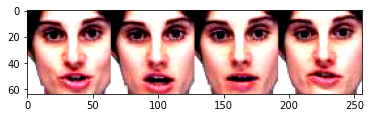

In [153]:
plt.imshow(0.5 + tmp.permute(1, 2, 0)/2)